Model Loaded successfully...
Detecting License Plate ... 
1/1 [==============================] - 0s 491ms/step


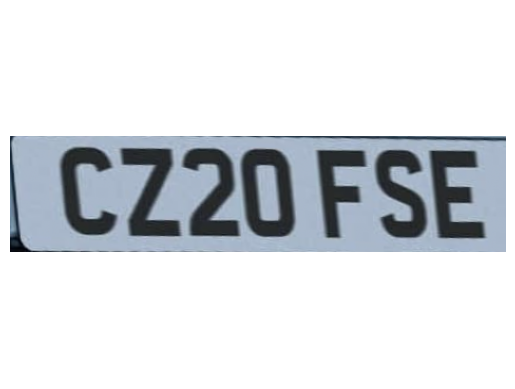

In [4]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models  import model_from_json
from keras.applications.mobilenet_v2 import preprocess_input
#from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from PIL import Image
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Model Loaded successfully...")
        print("Detecting License Plate ... ")
        return model
    except Exception as e:
        print(e)
wpod_net_path = "models/wpod-net.json"
wpod_net = load_model(wpod_net_path)

def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=608, Dmin = 608):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = "dataset\plate5.jpeg"
vehicle, LpImg, cor = get_plate(test_image_path)

fig = plt.figure()
plt.axis(False)
ax=fig.add_subplot()
plt.axis('off')
plt.imshow(LpImg[0])
extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.savefig('detection/placas.png', bbox_inches=extent)

In [5]:
def recognize_plate(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, None, fx = 3, fy = 3, interpolation = cv2.INTER_CUBIC)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    ret, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    dilation = cv2.dilate(thresh, rect_kern, iterations = 1)
    cv2.imwrite('detection/placas.png', dilation)

    try:
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    except:
        ret_img, contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    im2 = dilation.copy()
    
    return dilation

placa = cv2.imread('detection\placas.png')
imagen=recognize_plate(placa)
print(pytesseract.image_to_string(imagen))

| CZ20 FSE

